In [1]:
%matplotlib inline
#%matplotlib notebook
#%matplotlib widget
import matplotlib 
import numpy as np
import pandas as pd
import os, sys, time, random
#import ipywidgets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection    
 
# use LaTeX, choose nice some looking fonts and tweak some settings
matplotlib.rc('font', family='serif')
matplotlib.rc('font', size=16)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('legend', handlelength=1.5)
matplotlib.rc('legend', frameon=True)
matplotlib.rc('xtick.major', pad=7)
matplotlib.rc('xtick', direction="in")
matplotlib.rc('ytick', direction="in")
matplotlib.rc('xtick', top = True)
matplotlib.rc('ytick', right =True )
matplotlib.rc('xtick.minor', pad=7)
matplotlib.rc('text', usetex=True)
# matplotlib.rc('text.latex', 
#               preamble=[r'\usepackage[T1]{fontenc}',
#                         r'\usepackage{amsmath}',
#                         r'\usepackage{txfonts}',
#                         r'\usepackage{textcomp}'])

matplotlib.rc('figure', figsize=(12, 9))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda:0')

In [14]:
rawdatafolder = r"/home/jiyongso/jhjeon/multiplicity"
pkldatafolder = r"./data"
jjhdatafolder = r"/home/jiyongso/jhjeon/intermediate"


fn_pref = 'C1_1'
# Original ptrac file name. For memory.
file0 = fn_pref+'.p'

# file0 로부터 필요한 결과만 추출하여 정리한 파일의 이름들.
fn_carbon = fn_pref+'_carbon.o'
fn_proton = fn_pref+'_proton.o'
fn_photoelectric = fn_pref+'_photoelectric.o'
file_compton = fn_pref+'_compton.o'




In [46]:
def endp(x):
    return x.endswith(".p")

def get_pfile_names(dirpath):
    _, _, filelist = next(os.walk(dirpath))
    
    return list(filter(endp, filelist))
    

def read_jjh(inid=1, tid=None):
    if tid != None :
        fn0 = "C"+str(inid)+"_"+str(tid)
        fname_n = fn0+"_neutron_reduced.o"
        fname_p = fn0+"_photon_reduced.o"
        df_n = pd.read_csv(os.path.join(jjhdatafolder, fname_n), delimiter="\s+", header=None)

        df_n.columns = ["time", "cell", "Nhist", "origin1", "origin2"]

        df_p = pd.read_csv(os.path.join(jjhdatafolder, fname_p), delimiter="\s+", header=None)
        df_p.columns = ["time", "cell", "Nhist", "origin"]
        return df_n, df_p
    if tid == None :
        dfs_n = {}
        dfs_p = {}
        for tt in range(1, 21):
            df_n, df_p = read_jjh(inid, tt)
            dfs_n[fname_n]=df_n
            dfs_p[fname_p]=df_p
        return dfs_n, dfs_p
            
    
def ptrac_anaysis1(fn):
    """
    Carbon, Proton, Photoelectron, Compton
    """
    l_carbon=[]
    l_proton=[]
    l_photoelectric=[]
    l_compton = []
    h=1
    status = {"carbon" : False, "proton" : False, "electron" : False, "compton" : False}
    with open(os.path.join(rawdatafolder, fn)) as ff:
        for ln, line1 in enumerate(ff):
#             if ln > 2000:
#                 break
            if ln < 14:
                continue
            if ln == 14 :
                print(line1) 
            
            l1 = line1.split()
            if len(l1)< 7 :
                # start line of history
                if l1[1] == '1000' :
                    h+=1
                    continue
            else :
                line2 = next(ff)
                l2 = line2.split()
            
            ### carbon scattering
            if l1[2] == '6000' and l1[4] == '1':  
                l_carbon.append([float(l2[8]), int(l1[5]), h])
                
            ### proton production
            if status["proton"] and l1[4] == '9':  
                l_proton.append([float(l2[8]), int(l1[5]), h])     
                            
            if l1[0] == '2030' :
                status["proton"] = True
            else :
                status["proton"] = False
            
            ### electron production
            
            if status["electron"] and l1[4] == '3': 
                l_photoelectric.append([float(l2[8]), int(l1[5]), h])
 
            if l1[0] == '2011' and l1[4] == '2' :
                status["electron"] = True
            else :
                status["electron"] = False
            
            ### compton scattering
 
            if status["compton"] and l1[4] == '3':
                l_compton.append([float(l2[8]) , int(l1[5]), int(h)])       
            
            if l1[0] == '2012' and l1[4] == '2':
                status["compton"] = True
            else :
                status["compton"] = False
            
                
        df_carbon = pd.DataFrame({"time": [ll[0] for ll in l_carbon], 
                               "cell" : [ll[1] for ll in l_carbon], 
                               "Nhist": [ll[2] for ll in l_carbon]})
        df_proton = pd.DataFrame({"time": [ll[0] for ll in l_proton], 
                               "cell" : [ll[1] for ll in l_proton], 
                               "Nhist": [ll[2] for ll in l_proton]})
        df_photoelectric = pd.DataFrame({"time": [ll[0] for ll in l_photoelectric], 
                               "cell" : [ll[1] for ll in l_photoelectric], 
                               "Nhist": [ll[2] for ll in l_photoelectric]})
        df_compton = pd.DataFrame({"time": [ll[0] for ll in l_compton], 
                               "cell" : [ll[1] for ll in l_compton], 
                               "Nhist": [ll[2] for ll in l_compton]})
        
        
        
        return df_carbon, df_proton, df_photoelectric, df_compton

def ptrac_anaysis2(fn):
    """
    Neutron, photon(gamma)
    """
    
    l_neutron=[]
    l_photon=[]

    h=1
    status = {"carbon" : False, "proton" : False, "electron" : False, "compton" : False}
    with open(os.path.join(rawdatafolder, fn)) as ff:
        for ln, line1 in enumerate(ff):
#             if ln > 2000:
#                 break
            if ln < 14:
                continue
            if ln == 14 :
                print(line1) 
            
            l1 = line1.split()
            if len(l1)< 7 :
                # start line of history
                if l1[1] == '1000' :
                    h+=1
                    continue
            else :
                line2 = next(ff)
                l2 = line2.split()
            
            ### carbon scattering
            if l1[2] == '6000' and l1[4] == '1':  
                l_neutron.append([float(l2[8]), int(l1[5]), h])
                
            ### proton production
            if status["proton"] and l1[4] == '9':  
                l_neutron.append([float(l2[8]), int(l1[5]), h])     
                            
            if l1[0] == '2030' :
                status["proton"] = True
            else :
                status["proton"] = False
            
            ### electron production
            
            if status["electron"] and l1[4] == '3': 
                l_photon.append([float(l2[8]), int(l1[5]), h])
 
            if l1[0] == '2011' and l1[4] == '2' :
                status["electron"] = True
            else :
                status["electron"] = False
            
            ### compton scattering
 
            if status["compton"] and l1[4] == '3':
                l_photon.append([float(l2[8]) , int(l1[5]), int(h)])       
            
            if l1[0] == '2012' and l1[4] == '2':
                status["compton"] = True
            else :
                status["compton"] = False
            
                
        df_neutron = pd.DataFrame({"time": [ll[0] for ll in l_neutron], 
                               "cell" : [ll[1] for ll in l_neutron], 
                               "Nhist": [ll[2] for ll in l_neutron]})
        df_photon = pd.DataFrame({"time": [ll[0] for ll in l_photon], 
                               "cell" : [ll[1] for ll in l_photon], 
                               "Nhist": [ll[2] for ll in l_photon]})
        
        
        return df_neutron, df_photon
    
def ptrac_reduce(df):
    return df.drop_duplicates(subset=["cell", "Nhist"], keep="first")


def ptrac_analysys_reduce(inid, tid):
    prefix="C"+str(inid)+"_"+str(tid)
    fn = prefix+".p"
    ln, lp = ptrac_anaysis2(fn)
    lnr=ptrac_reduce(ln)
    lpr=ptrac_reduce(lp)
    
    return (prefix, lnr, lpr)

def ptrac_reduce_save(inid, tid):
    prefix, lnr, lpr = ptrac_analysys_reduce(inid, tid)
    lnr.to_pickle(os.path.join(pkldatafolder, prefix+"_neutron.pkl"))
    lpr.to_pickle(os.path.join(pkldatafolder, prefix+"_photon.pkl"))

def ptrac_analysis_reduce_all(num=1):
    prefix="C"+str(num)+"_"
    finalresult = {}

    for i in range(1, 11):
        fn = prefix+str(i)+".p"
        print(fn+" start.")
        ln, lp = ptrac_anaysis2(fn)
        finalresult[prefix+str(i)+"_neutron"]=ptrac_reduce(ln)
        finalresult[prefix+str(i)+"_photon"]=ptrac_reduce(lp)

    return finalresult


def ptrac_combine(inid):
    fnprefix = "C"+str(inid)
    _, _, filelist= list(os.walk(pkldatafolder))[0]
    files1 = [l for l in filelist if l.startswith("C"+str(inid))]
    files = [l for l in filelist if l.endswith("pkl")]
    neutrons={}
    photons={}
    for filename in files:
        tdf = pd.read_pickle(os.path.join(pkldatafolder, filename))
        kid = int(filename.split("_")[1])
        tdf["time"]=tdf["time"]+100000*(kid-1)
        if filename[:-4].endswith("neutron"):
            neutrons[filename[:-4]]=tdf
        elif filename[:-4].endswith("photon"):
            photons[filename[:-4]]=tdf
    
    dfn = pd.concat(list(neutrons.values()))
    dfp = pd.concat(list(photons.values()))
    
    valid_cell = {121, 122, 123, 124, 125, 126, 127, 128, 129, 141, 142, 143, 
                 221, 222, 223, 224, 225, 226, 227, 228, 229, 241, 242, 243, 
                 321, 322, 323, 324, 325, 326, 327, 328, 329, 341, 342, 343} 
    
    n_cell = set(dfn["cell"].unique())
    p_cell = set(dfn["cell"].unique())
    
    nn0, pp0 = n_cell- valid_cell, p_cell-valid_cell
    if len(nn0)>0 :
        for nn in nn0:
            dfn = dfn[dfn["cell"]!=nn]
    if len(pp0)>0 :
        for pp in pp0 :
            dfp = dfp[dfp["cell"]!=pp]
    
    dfn.sort_values("time", inplace=True, ignore_index=True)
    dfp.sort_values("time", inplace=True, ignore_index=True)
    return dfn, dfp


def ptrac_rossy(df):
    tdata = df["time"].to_numpy()
    print(tdata)
    result = []
    i=1
    while True :
        ts = tdata[i:]-tdata[:-i]
        if (ts<100).any():
            result.append(ts[ts<100])
            i+=1
        else :
            break
    return result
        
    
    
    
    
    
    

In [138]:
# t1=time.time()
# lca, lpr, lph, lcp=ptrac_anaysis1(file0)
# print(time.time()-t1)

          3      1000         0         8  1.00000E+00

79.18606781959534


In [4]:
nn, pp = ptrac_combine(1)

In [5]:
nrossy = ptrac_rossy(nn)

[1.80870e-01 1.87800e-01 1.92980e-01 ... 1.38975e+10 1.60906e+10
 3.46943e+10]


In [6]:
qq = np.concatenate(nrossy)

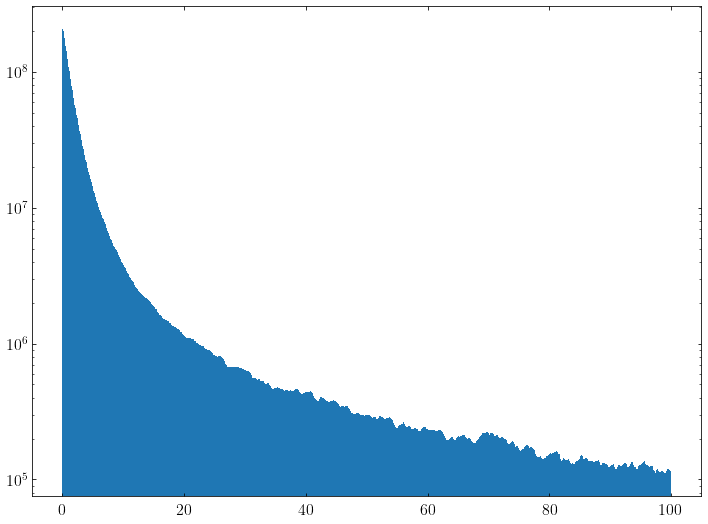

In [8]:
plt.hist(qq, bins=1000)
plt.yscale('log')

In [12]:
for tid in range(1, 11):
    ptrac_reduce_save(3, tid)

In [13]:
ptrac_reduce_save(3, 10)

          1      1000         0         8  1.00000E+00



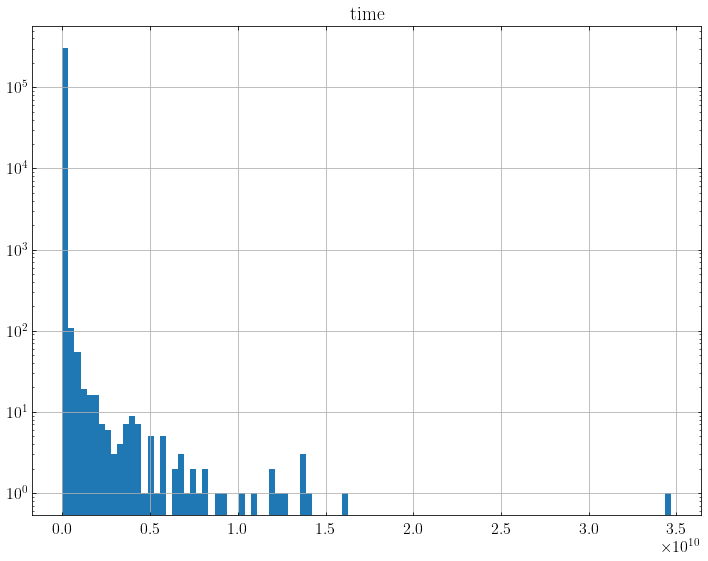

In [143]:
nn.hist("time", bins=100)
plt.yscale("log")

In [134]:
nn

,time,cell,Nhist
15314,1.808700e-01,126,13443
12955,1.878000e-01,343,11396
37223,1.929800e-01,125,32538
2289,2.036700e-01,125,1940
43854,2.075800e-01,121,38443
...,...,...,...
25674,1.360970e+10,228,22618
25686,1.360970e+10,328,22618
41112,1.389750e+10,323,35986
31477,1.609060e+10,224,28175


In [114]:
nn["cell"].unique()

array([123, 341, 326, 228, 324, 241, 125, 222, 122, 226, 143, 224, 321,
       142, 129, 328, 126, 121, 225, 141, 243, 229, 242, 323, 343, 342,
       322, 124, 127, 327, 325, 128, 221, 329, 223, 227])

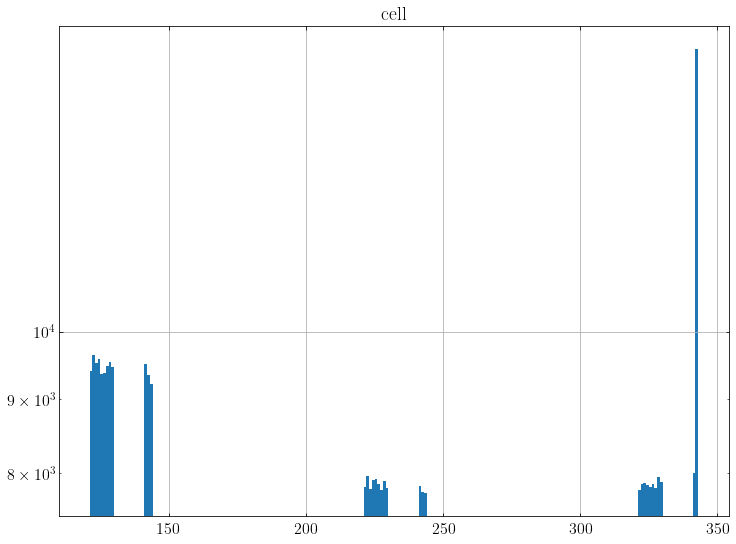

In [113]:
nn.hist("cell", bins=np.arange(121, 344))
plt.yscale('log')

In [85]:
t1=time.time()
ln, lp = ptrac_anaysis2(file0)
print(time.time()-t1)

          3      1000         0         8  1.00000E+00

79.95544338226318


In [8]:
t1=time.time()
ptrac_combine_save(1, 3)
print(time.time()-t1)

          3      1000         0         8  1.00000E+00

1249.073888540268


In [9]:
for i in range (4, 11):
    t1=time.time()
    ptrac_combine_save(1, i)
    print(time.time()-t1)

          1      1000         0         8  1.00000E+00

1304.7726390361786
          3      1000         0         8  1.00000E+00

1395.1680355072021
          1      1000         0         8  1.00000E+00

1501.0007464885712
          2      1000         0         8  1.00000E+00

1541.7056803703308
          1      1000         0         8  1.00000E+00

1621.9005949497223
          3      1000         0         8  1.00000E+00

1701.4434967041016
          1      1000         0         8  1.00000E+00

1788.7790625095367


In [5]:
c1ingot={}
for i in range(1, 11):
    nname="C1_"+str(i)+"_neutron"
    pname="C1_"+str(i)+"_photon"
    c1ingot[nname]=pd.read_pickle(nname+".pkl")
    c1ingot[pname]=pd.read_pickle(pname+".pkl")

In [64]:
dfn1, dfp1 = read_jjh(3, 1)
dfn2, dfp2 = read_jjh(3, 2)
dfn = pd.concat([dfn1, dfn2])

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

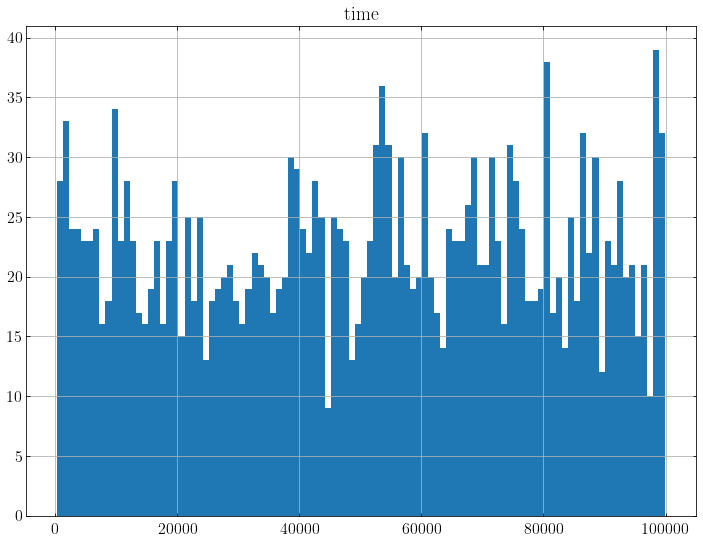

In [65]:
dfn.hist("time", bins=100)

In [66]:
dfn2=pd.read_pickle("./data/C3_1_neutron.pkl")

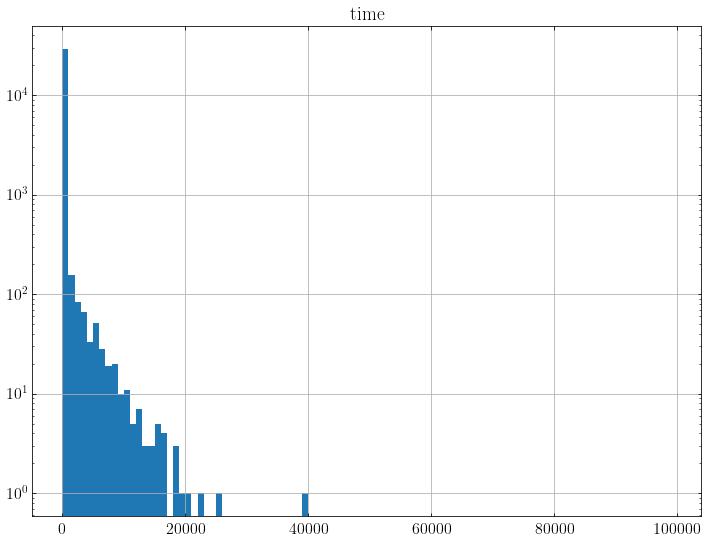

In [67]:
dfn2.hist("time", bins=np.arange(0, 100000, 1000))
plt.yscale('log')

In [45]:
pd.read_csv(os.path.join(jjhdatafolder, "C3_1_photon_reduced.o"), delimiter="\s+", header=None)

,0,1,2,3
0,39641.0,1,2,photoelectric
1,61110.0,1,3,photoelectric
2,6362.3,1,4,photoelectric
3,55139.0,1,5,photoelectric
4,37798.0,1,6,compton
...,...,...,...,...
1724,42662.0,221,1518,compton
1725,42662.0,1,1518,photoelectric
1726,37867.0,1,1519,photoelectric
1727,13563.0,1,1520,photoelectric


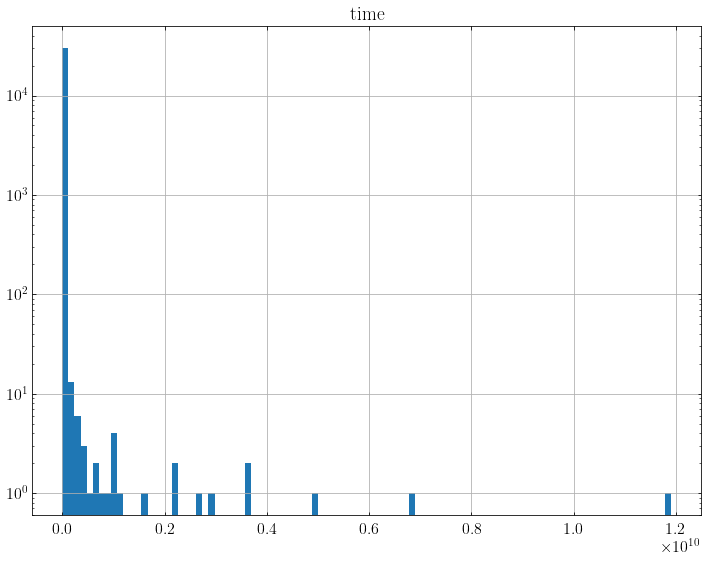

In [7]:
ln2.hist("time", bins=100)
plt.yscale('log')

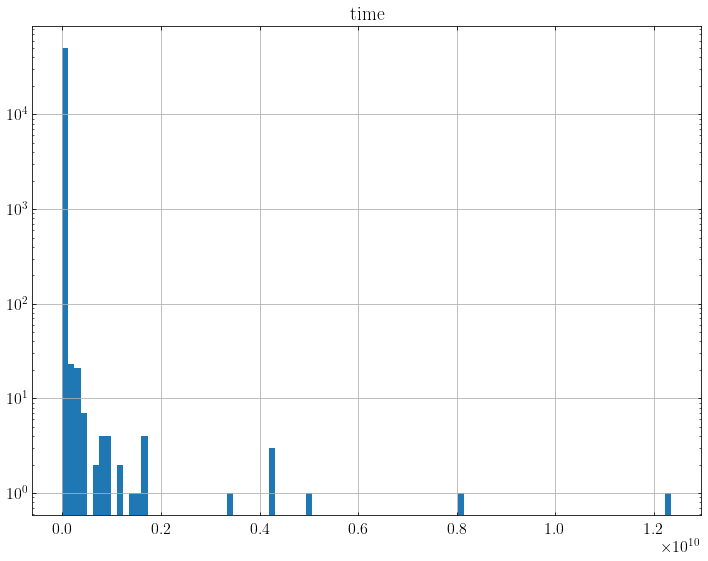

In [73]:
ln.hist("time", bins=100)
plt.yscale('log')

In [74]:
ln.time.max()

12348000000.0

In [8]:
def endp(x):
    return x.endswith(".p")
pfiles = list(filter(endp, filelist))
str1=""
for pfile in pfiles :
    f1=open(os.path.join(rawdatafolder, pfile), "r")
    f1.readline()
    f1.readline()
    str1+="%11s"%pfile+" "+f1.readline()
    f1.close()
print(str1)

NameError: name 'filelist' is not defined

In [39]:
24*20

480

In [68]:
result = []
i=0
j=1
for k in range(1, lca.shape[0]):
    result.append([lca.iloc[i]["time"], lca.iloc[i]["cell"], lca.iloc[i]["Nhist"]])
    while (lca.iloc[i]["cell"]==lca.iloc[i+j]["cell"]) and (lca.iloc[i]["Nhist"]==lca.iloc[i]["Nhist"]):
        j+=1
        k=i+j
        if k >= lca.shape[0]-1 :
            break
    i+=j
    j=1
    if i>=lca.shape[0]-1:
        break
        
    


In [97]:
lca_reduced = lca.drop_duplicates(subset=["Nhist", "cell"], keep="first")


In [108]:
lca_reduced["time"].data

AttributeError: 'Series' object has no attribute 'data'

In [99]:
for i in range(40, 100):
    print(lca_reduced.iloc[i]["time"], result[i][0])

1.0733 1.0733
2.7386 2.7386
24.915 24.915
5457.5 5457.5
2.0709 2.0709
0.39759 0.39759
2.9062 2.9062
0.93115 0.93115
780.62 780.62
4571.3 4571.3
1.4719 1.4719
6.7357 6.7357
2.7562 2.7562
0.9759 0.9759
1.2245 1.2245
4.5824 4.5824
7.033 7.033
2.7882 2.7882
2.5738 2.5738
0.62638 0.62638
0.84448 0.84448
1.4896 1.4896
5.7593 5.7593
160.38 160.38
2.1348 2.1348
0.72552 0.72552
1.7112 1.7112
0.75004 0.75004
0.37421 0.37421
1.6533 1.6533
2.5128 2.5128
3838.2 3838.2
7059.3 7059.3
7.0832 7.0832
0.88118 0.88118
1.4708 1.4708
0.67878 0.67878
2.1687 2.1687
3.7073 3.7073
2.7781 2.7781
0.71139 0.71139
1.2079 1.2079
1.4757 1.4757
5.4618 5.4618
11.181 11.181
0.54253 34.634
1.4997 0.54253
2.764 1.4997
3.9494 2.764
1.1034 3.9494
2.5839 1.1034
4.2048 2.5839
0.55648 4.2048
12.215 0.55648
7.4536 12.215
3.014 7.4536
1.2773 3.014
3.3158 1.2773
1.7666 3.3158
2.4634 1.7666


In [102]:
q1=lca[lca["time"]<34.635]
q2=q1[q1["time"]>34.633]

In [43]:
20*480/1000

9.6